In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
# load some utilities (for loading MNIST and plotting)
# also imports most Python modules
_#%run utils.py

# load MNIST training and test data sets
train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
#train_dataset, test_dataset = MNIST_datasets()

# load tensors with all MNIST images and labels
#train_data, train_labels = MNIST()
#test_images, test_labels = MNIST(test=True)

train_data = train_dataset.data/255
train_labels = train_dataset.targets

train_images = train_dataset.data/255
train_labels = train_dataset.targets

test_images = test_dataset.data/255
test_labels = test_dataset.targets

In [ ]:
print(((train_images[0,:,:]/255)))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

# Variational Autoencoder

Is it reasonable to assume that we can generate images similar to the ones in the MNIST data set by a linear transformation of low dimensional latent variables?

Let us reflect on the limitations of PCA and PPCA. In both models, data is encoded in a lower dimensional space by a linear (or rather affine) transformation, and the lower dimensional representation can be decoded
by another affine function. One implication is that relative distances are preserved between the original space and the lower-dimensional latent space: if two data samples are "close" to each other, then also their latent encodings are relatively "close" to each other, and similarly two latent encodings that are "close" to each other are decoded to two relatively "close" data points. This affects our ability to reconstruct images from their encodings and to generate new images.

## Task 1

Answer Question 4.7 in the lab instructions.

Let us consider a more flexible non-linear model that is given by 
\begin{align*}
  p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}\right), \\
  p_{\boldsymbol{\theta}}(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2),
\end{align*}
where parameters $\boldsymbol{\theta}$ include variance parameter $\sigma^2_{\boldsymbol{\theta}} > 0$ and $\mu_{\boldsymbol{\theta}} \colon \mathbb{R}^2 \to \mathbb{R}^{784}$ is a nonlinear model of the mean of the normal distribution. In this lab we model $\mu_{\boldsymbol{\theta}}$ by a neural network and include its weights and biases in $\boldsymbol{\theta}$, but other models could be used equally well.

This nonlinear model looks similar to the PPCA model above. However, in contrast to the PPCA model, for most classes of functions $\mu_{\boldsymbol{\theta}}$ the marginal distribution of $\mathbf{x}$ is not a normal distribution anymore, and typically there exists not even a closed form expression for its density.
Thus usually we can not learn the parameters $\boldsymbol{\theta}$ in the same straightforward way as for the PPCA model by minimizing the negative log-likelihood with gradient descent.

## Training: First approach ("naive")

If there exists no closed-form expression for $p_{\boldsymbol{\theta}}(\mathbf{x})$,
alternatively one could approximate the integral
\begin{equation*}
  p_{\boldsymbol{\theta}}(\mathbf{x}) = \int p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) p_{\boldsymbol{\theta}}(\mathbf{z}) \,\mathrm{d}\mathbf{z}
\end{equation*}
with the Monte Carlo method by a finite sum, i.e., one could work with the
estimation
\begin{equation}
  p_{\boldsymbol{\theta}}(\mathbf{x}) \approx \frac{1}{K} \sum_{n=1}^K p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_n),
\end{equation}
where $\mathbf{z}_1, \ldots, \mathbf{z}_K$ are i.i.d. samples of $\mathbf{z}$. Thus for our nonlinear model we would obtain
\begin{equation*}
  \begin{split}
  \log p_{\boldsymbol{\theta}}(\mathbf{x}) &\approx \log{\left(\sum_{n=1}^K \mathcal{N}(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}_n), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}) \right)} - \log K \\
  &= \log{\left({(2\pi \sigma_{\boldsymbol{\theta}}^2)}^{-392} \sum_{n=1}^K \exp{\left(-\frac{1}{2\sigma_{\boldsymbol{\theta}}^2} {\|\mathbf{x} - \mu_{\boldsymbol{\theta}}(\mathbf{z}_n)\|}_2^2 \right)}\right)} - \log K \\
  &= - 392 (\log \sigma_{\boldsymbol{\theta}}^2 + \log{(2\pi)}) + \log{\left(\sum_{n=1}^K \exp{\left(-\frac{1}{2\sigma_{\boldsymbol{\theta}}^2} {\|\mathbf{x} - \mu_{\boldsymbol{\theta}}(\mathbf{z}_n)\|}_2^2 \right)}\right)} - \log K.
  \end{split}
\end{equation*}
Hence similar to the PPCA model, with a training data set $\mathbf{x}_1, \ldots, \mathbf{x}_N$ we can try to minimize the cost function
\begin{equation*}
  J(\boldsymbol{\theta}) = 392 \log \sigma_{\boldsymbol{\theta}}^2 - \frac{1}{N} \sum_{n'=1}^N \log{\left(\sum_{n=1}^K \exp{\left(-\frac{1}{2\sigma_{\boldsymbol{\theta}}^2} {\|\mathbf{x}_{n'} - \mu_{\boldsymbol{\theta}}(\mathbf{z}_n)\|}_2^2 \right)}\right)}
\end{equation*}
using gradient descent.

\begin{equation*}
  \frac{dJ(\boldsymbol{\theta})}{dO_L} = -\frac{1}{N} \sum^{N}_{n'= 1} \left( \frac{1}{\sigma^{2}_{\theta}} ||\bar{\mu_{\theta}}\bar{z_n} - \bar{x_{n'}}|| \right)
\end{equation*}

\begin{equation*}
  \frac{df(O_L)}{dO_L} = dReLu(O_L)
\end{equation*}

\begin{equation*}
  \frac{dO_L}{dw_L} = ReLu(O_L)
\end{equation*}


\begin{equation*}
  \frac{dJ(\boldsymbol{\theta})}{dx} = -\frac{1}{N} \sum^{N}_{n'= 1} \left( \frac{1}{\sigma^{2}_{\theta}} ||\bar{x_{n'}} - \bar{\mu_{\theta}}\bar{z_n}|| \right)
\end{equation*}

https://mustafaghali11.medium.com/how-pytorch-backward-function-works-55669b3b7c62

We now consider the following nonlinear model. The function $\mu_{\boldsymbol{\theta}}$ is modeled by a shallow neural network. The `decode` function outputs the representative decoding $\mu_{\boldsymbol{\theta}}(\mathbf{z})$ for a batch of encodings $\mathbf{z}$.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NonLinearModel(nn.Module):

    def __init__(self):
        super(NonLinearModel, self).__init__()

        # linear parts of the nonlinear function mu_theta
        self.decoder_fc1 = nn.Linear(2, 400)
        self.decoder_fc2 = nn.Linear(400, 784)
        

        # logarithm of variance sigma_theta^2
        self.logsigma2 = nn.Parameter(torch.zeros(1))

    def decode(self, z):
        h1 = F.relu(self.decoder_fc1(z))
        return self.decoder_fc2(h1)

## Task 2

Read through the definition of the nonlinear model and try to understand how $\mu_{\boldsymbol{\theta}}$ is defined.

We start by implementing the cost function that we derived above. One important part in the evaluation of the cost function is the sampling of $\mathbf{z}_1, \ldots, \mathbf{z}_K$ and the computation of the decodings $\mu_{\boldsymbol{\theta}}(\mathbf{z}_i)$.

## Task 3

Implement the following function `sample_decode(model, K)` that returns a matrix of size $K \times 784$ whose rows are the decodings $\mu_{\boldsymbol{\theta}}(\mathbf{z}_i) \in \mathbb{R}^{784}$ of samples $\mathbf{z}_1, \ldots, \mathbf{z}_K \in \mathbb{R}^2$ from $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$, where $\boldsymbol{\theta}$ are the parameters of the nonlinear model `model`.

*Hint*: You can sample a PyTorch matrix of size $n \times m$ with standard normally distributed entries with [`torch.randn(n, m)`](https://pytorch.org/docs/stable/torch.html#torch.randn).

In [100]:
def sample_decode(model, K):
    # sample z
    # WRITE YOUR CODE HERE
    #z = torch.randn(K,2)
    z =torch.Tensor(np.ones([K,2]))
    # compute mu(z)
    # WRITE YOUR CODE HERE
    
    return model.decode(z) # WRITE YOUR CODE HERE

We use the function `sample_decode` to evaluate the cost function.

In [ ]:
def cost_function(X, model, K):
    # decodings mu(z) of samples z
    mu = sample_decode(model, K)

    y = - 0.5 * torch.exp(-model.logsigma2) * (X.view(-1, 1, 784) - mu.view(1, -1, 784)).pow(2).sum(dim=2)
    
    # compute loss
    return 392 * model.logsigma2 - torch.logsumexp(y, dim=1).mean()

In [106]:
import numpy as np
import torch.optim as optim

#x = torch.tensor(np.ones([28,28]))

x = train_dataset.data[0]/255

# define the model
model = NonLinearModel()

model.decoder_fc1.weight.data = model.decoder_fc1.weight.data*0.0 +0.1
model.decoder_fc2.weight.data = model.decoder_fc2.weight.data*0.0 +0.1

model.decoder_fc1.bias.data = model.decoder_fc1.bias.data*0.0 +0.1 
model.decoder_fc2.bias.data = model.decoder_fc2.bias.data*0.0 +0.1

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss = cost_function(x, model, 1)

print(model.decoder_fc1.weight.data[0:2])
loss.backward()
optimizer.step()
print(loss)

print(model.decoder_fc1.weight.data[0:2])

loss = cost_function(x, model, 1)
loss.backward()
optimizer.step()
print(loss)

print(model.decoder_fc1.weight.data[0:2])


tensor([[0.1000, 0.1000],
        [0.1000, 0.1000]])
tensor([57391.5273], grad_fn=<SubBackward0>)
tensor([[0.0900, 0.0900],
        [0.0900, 0.0900]])
tensor([37352.0195], grad_fn=<SubBackward0>)
tensor([[0.0802, 0.0802],
        [0.0802, 0.0802]])


We train the nonlinear model with stochastic gradient descent using batches of 500 images of the MNIST training data set for 20 epochs. In every iteration we use $K=5$ randomly sampled latent vectors $\mathbf{z}_n$ to evaluate the cost function.

In [80]:
import torch.optim as optim
# define the data loaders
train_dataset.data = train_dataset.data/255
test_dataset.data = test_dataset.data/255
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=500)

# define the model
model = NonLinearModel()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# track the training and test loss
training_loss = []
test_loss = []

# optimize parameters for 20 epochs
for i in range(20):
    # for each minibatch
    for x, _ in train_data:

        # evaluate the cost function on the training data set
        loss = cost_function(x, model, 5)

        # update the statistics
        training_loss.append(loss.item())
        test_loss.append(float('nan'))

        # perform backpropagation
        loss.backward()

        # perform a gradient descent step
        optimizer.step()
        
        # reset the gradient information
        optimizer.zero_grad()

    # evaluate the model after every epoch
    with torch.no_grad():

        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for x, _ in test_data:
            loss = cost_function(x, model, 5)
            accumulated_loss += loss.item()
            
        # update the statistics
        test_loss[-1] = accumulated_loss / len(test_data)
            
    print(f"Epoch {i + 1:2d}: training loss {training_loss[-1]: 9.3f}, "
          f"test loss {test_loss[-1]: 9.3f}")
        
# plot loss
plt.figure()
iterations = np.arange(1, len(training_loss) + 1)
plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

KeyboardInterrupt: 

## Task 4

Read through and try to understand the implementation of the training procedure above. How does it differ from the implementation of the training procedure of the PPCA model?

We can use the trained model to generate new images, in the same way as we did with the PPCA model. Again we sample 25 encodings $\mathbf{z}_1, \ldots, \mathbf{z}_{25}$ from $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_{2})$, and plot their representative decodings $\mu_{\boldsymbol{\theta}}(\mathbf{z}_n)$.

In [ ]:
import cv2
with torch.no_grad():
  x = sample_decode(model, 25)

for img in x:

  #print(np.shape(img.reshape(28,28)))
  numimg = img.reshape(28,28)

  plt.imshow(numimg, cmap='gray')
  plt.show()

NameError: ignored

## Training: second approach (variational autoencoder)

### Introduction

There are at least two problems with the nonlinear model and our training procedure so far:
- For most samples of
$\mathbf{z}$, $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is almost zero. Hence these
terms will not contribute much to the estimation of $p_{\boldsymbol{\theta}}(\mathbf{x})$,  which can slow down the training procedure.
- An even more fundamental problem with the nonlinear model is the fact that
usually we can not compute an analytical expression for
$p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Thus we can not encode
data in the lower dimensional latent space and analyze its structure.

The main idea of a so-called variational autotoencoder (VAE) is to resolve the first issue by attempting to obtain samples
$\mathbf{z}$ for which $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is large.

### ELBO

Let us define an encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ that may depend on $\mathbf{x}$ and some parameters $\boldsymbol{\phi}$. As shown in the lecture, then we have
\begin{equation*}
    \log p_{\boldsymbol{\phi}}(\mathbf{x}) =
    \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
    + \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z} \,|\,\mathbf{x})\big) - \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big),
\end{equation*}
for all $\mathbf{x}$ (we ignore here that the KL-divergence $\mathrm{KL}(p \,\|\, q)$ is only defined if $q_{\boldsymbol{\phi}}(x) = 0$ implies $p_{\boldsymbol{\theta}}(x) = 0$).

The KL divergence of two distributions is always non-negative, and zero if and only if the two distributions are equal. Hence we have for all $\mathbf{x}$
\begin{equation*}
  \log p_{\boldsymbol{\theta}}(\mathbf{x}) \geq
  \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
  - \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big)
\end{equation*}
with equality if and only if $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is equal to
the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Since the
right-hand side of this inequality is a lower bound of the evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$, it is called evidence lower bound (ELBO).

Remember that we know $p_{\boldsymbol{\theta}}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2)$ from the model specification. Moreover, $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is an
arbitrary distribution that we can define in such a way that we can
compute $\mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big)$
analytically. From the lab instructions, we know that we obtain
\begin{equation*}
    \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big) = \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n\right),
\end{equation*}
if we choose the encoding distribution
\begin{equation}\label{eq:encoder}
  q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))),
\end{equation}
where $\mu_{\boldsymbol{\phi}}(\cdot) \colon \mathbb{R}^{784} \to \mathbb{R}^2$ defines the mean of the normal distribution and $\sigma_{\boldsymbol{\phi}}^2 \colon \mathbb{R}^{784} \to \mathbb{R}_{\geq 0}^2$ are the diagonal entries of the covariance matrix.

Thus for this encoding distribution the ELBO is
\begin{equation}
 \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x})))}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
 - \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))\right),
\end{equation}
which we can approximate with the Monte Carlo estimate
\begin{equation}
  \frac{1}{K} \sum_{n=1}^K \log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_n) - \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n\right),
\end{equation}
where $\mathbf{z}_1, \ldots, \mathbf{z}_K$ are independent samples from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})= \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x})))$.  The fundamental difference to the Monte Carlo estimation of the log-likelihood above is that before we had to sample from $p_{\boldsymbol{\theta}}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2)$ whereas now we sample them from the encoding distribution $q$. Thus hopefully we can tune the parameters $\boldsymbol{\phi}$ of the encoding distribution such that $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_n)$ increases, i.e., that it becomes more likely to reconstruct $\mathbf{x}$ from the samples $\mathbf{z}_n$.

This observation motivates the idea of maximizing the ELBO by training parameters $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ simultaneously instead of maximizing the evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$ by training only $\boldsymbol{\theta}$. If the encoding distribution is flexible enough, we might even be able to obtain the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$, in which case the ELBO is actually
equal to the evidence.

Additionally, if we manage that distribution $q$ becomes equal to the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$ (or at least close to it), we have found a way to encode our data: for a given data sample $\mathbf{x}$, we can just sample the latent encoding from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$. So by introducing the encoding distribution and maximizing the ELBO, we might be able to solve both problems of the nonlinear model.

### Cost function

In the same way, for a set of training data $\mathbf{x}_1, \ldots, \mathbf{x}_N$ we obtain
\begin{equation*}
    \begin{split}
    \log p_{\boldsymbol{\theta}}(\mathbf{x}_1, \ldots, \mathbf{x}_N) &= \sum_{n=1}^N \log p_{\boldsymbol{\theta}}(\mathbf{x}_n) \\
    &\geq \sum_{n=1}^N \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x}_n \,|\, \mathbf{z})\big] \\
   &\quad - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
    \end{split}
\end{equation*}
and thus we can estimate the joint ELBO by
\begin{equation*}
    \begin{split}
     & \sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \log p_{\boldsymbol{\theta}}(\mathbf{x}_n \,|\, \mathbf{z}_{n,n'})
  - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_i\right) \\
     ={}& - \frac{1}{2}\left(784 N \left(\log{(2\pi)} + \log{\sigma_{\boldsymbol{\theta}}^2})\right) + \frac{1}{\sigma_{\boldsymbol{\theta}}^2}\sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \|\mu_{\boldsymbol{\theta}}(\mathbf{z}_{n,n'}) - \mathbf{x}_n\|^2_2 \right) \\
     & - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
     \end{split}
\end{equation*}
where $\mathbf{z}_{n,1}, \ldots, \mathbf{z}_{n,N}$ are independent samples of the encoding distribution $\mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$.

Since we use a stochastic optimization algorithm anyway, we choose $K = 1$, i.e., we use only one Monte Carlo sample for each training data sample. After neglecting additive constant terms and scaling by $N/2$, we obtain the cost function
\begin{equation*}
 J(\boldsymbol{\theta}, \boldsymbol{\phi}) = 784 \log{\sigma_{\boldsymbol{\theta}}^2} + \frac{1}{N \sigma_{\boldsymbol{\theta}}^2} \sum_{n=1}^N  \|\mu_{\boldsymbol{\theta}}(\mathbf{z}_n) - \mathbf{x}_n\|^2_2 + \frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation*}
where $\mathbf{z}_n$ are samples from $\mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$. We will minimize this cost function with stochastic gradient descent.

### Reparameterization trick

However, there is one problem: it is not clear how to differentiate through the sampling operation of $\mathbf{z}_n$ with respect to the parameters $\boldsymbol{\phi}$ that determine the mean and variance of the distribution we sample from. We can generate samples from an arbitrary normal distribution by an affine transformation of standard normally distributed samples. Thus we can rewrite the cost function as
\begin{equation*}
    \begin{split}
 J(\boldsymbol{\theta}, \boldsymbol{\phi}) &= 784 \log{\sigma_{\boldsymbol{\theta}}^2} + \frac{1}{N \sigma_{\boldsymbol{\theta}}^2} \sum_{n=1}^N  \|\mu_{\boldsymbol{\theta}}(\mu_{\boldsymbol{\phi}}(\mathbf{x}_n) + \mathrm{diag}(\sigma_{\boldsymbol{\phi}}(\mathbf{x}_n)) \boldsymbol{\epsilon}_n) - \mathbf{x}_n\|^2_2 \\
 &\quad + \frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
 \end{split}
\end{equation*}
where $\boldsymbol{\epsilon}_n$ are samples from the normal distribution $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$. Rewriting the cost function in this form is known as reparameterization trick and allows us to differentiate the cost function with respect to $\boldsymbol{\phi}$ in a straightforward way, since the samples $\boldsymbol{\epsilon}_n$ do not depend on the parameters anymore.

We now consider the following nonlinear model, in which in addition to the nonlinear model above we also implement an encoding distribution. The mean and the logarithm of the diagonal entries of the covariance matrix of the encoding distribution are modeled by a shallow neural network, and the `encode` function returns them for a batch of inputs. As above, the `decode` function outputs the representative decoding for a batch of encodings.

In [6]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        # linear parts of the nonlinear encoder
        self.encoder_fc1 = nn.Linear(784, 400)
        self.encoder_fc2_mean = nn.Linear(400, 2)
        self.encoder_fc2_logsigma2 = nn.Linear(400, 2)

        # linear parts of the nonlinear function mu_phi
        self.decoder_fc1 = nn.Linear(2, 400)
        self.decoder_fc2 = nn.Linear(400, 784)

        # logarithm of variance sigma_phi^2
        self.logsigma2 = nn.Parameter(torch.zeros(1))

    def encode(self, x):
        h1 = F.relu(self.encoder_fc1(x))
        return self.encoder_fc2_mean(h1), self.encoder_fc2_logsigma2(h1)

    def decode(self, z):
        h1 = F.relu(self.decoder_fc1(z))
        return self.decoder_fc2(h1)

## Task 5

Read through and try to understand the definition of the nonlinear model.

As discussed above, one term of the cost function is the term
\begin{equation}
\frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation}
that originates from the KL divergence expression in the ELBO.

## Task 6

Implement the function `kl_divergence_term(Z_mu, Z_logsigma2)` that evaluates the expression above, where the rows of `Z_mu` are $\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)$ and the rows of `Z_logsigma2` are $\begin{bmatrix} \log (\sigma^2_{\boldsymbol{\phi}}(\mathbf{x}_n))_1 & \log (\sigma^2_{\boldsymbol{\phi}}(\mathbf{x}_n))_2\end{bmatrix}^\intercal$.

*Hint*: You should probably use the PyTorch functions [`torch.mean`](https://pytorch.org/docs/stable/torch.html#torch.mean), [`torch.sum`](https://pytorch.org/docs/stable/torch.html#torch.sum), [`torch.exp`](https://pytorch.org/docs/stable/torch.html#torch.exp), and [`torch.pow`](https://pytorch.org/docs/stable/torch.html#torch.pow) in your implementation.

In [7]:
def kl_divergence_term(Z_mu, Z_logsigma2):
    # compute the average KL divergence to the standard normal
    # distribution, neglecting additive constant terms
    sigma2 = torch.exp(Z_logsigma2)

    term = torch.mean(torch.sum(sigma2 ,dim=1) + torch.sum(torch.pow(Z_mu ,2), dim=1) - torch.sum(Z_logsigma2, dim=1))
    return term# WRITE YOUR CODE HERE

We make use of the `kl_divergence_term` function in our implementation of the cost function.

In [8]:
def cost_function(X, model):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    Z_mu, Z_logsigma2 = model.encode(X)

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl = kl_divergence_term(Z_mu, Z_logsigma2)

    # sample z
    Z = Z_mu + torch.randn(Z_mu.size()) * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    X_decoding = model.decode(Z)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence = 784 * model.logsigma2 + \
        torch.sum((X_decoding - X).pow(2) * torch.exp(- model.logsigma2), dim=1).mean()

    return neg_log_evidence + kl

Now we can train the nonlinear model.

Epoch  1: training loss  -538.880, test loss  -543.708
Epoch  2: training loss -1228.003, test loss -1226.261
Epoch  3: training loss -1522.057, test loss -1518.554
Epoch  4: training loss -1594.272, test loss -1587.927
Epoch  5: training loss -1612.911, test loss -1613.596
Epoch  6: training loss -1624.384, test loss -1630.718
Epoch  7: training loss -1646.322, test loss -1634.731
Epoch  8: training loss -1654.878, test loss -1652.138
Epoch  9: training loss -1639.910, test loss -1656.452
Epoch 10: training loss -1662.911, test loss -1659.485
Epoch 11: training loss -1677.654, test loss -1668.670
Epoch 12: training loss -1666.085, test loss -1674.262
Epoch 13: training loss -1641.069, test loss -1672.952
Epoch 14: training loss -1687.537, test loss -1678.018
Epoch 15: training loss -1666.380, test loss -1673.434
Epoch 16: training loss -1701.212, test loss -1678.875
Epoch 17: training loss -1683.367, test loss -1681.167
Epoch 18: training loss -1715.219, test loss -1687.499
Epoch 19: 

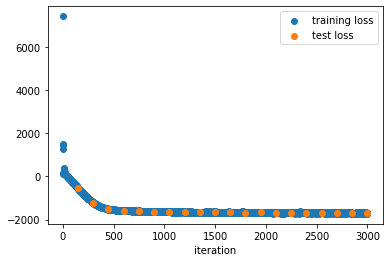

In [9]:
import torch.optim as optim

train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
# define the data loaders
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=400, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=400)

# define the model
model = VAE()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# track the training and test loss
training_loss = []
test_loss = []


# optimize parameters for 20 epochs
for i in range(20):

    # for each minibatch
    for x,_ in train_data:
        x = x.reshape(400,28*28)
        #print((x[0,:]))
        # evaluate the cost function on the training data set
        loss = cost_function(x, model)

        # update the statistics
        training_loss.append(loss.item())
        test_loss.append(float('nan'))

        # perform backpropagation
        loss.backward()

        # perform a gradient descent step
        optimizer.step()
        
        # reset the gradient information
        optimizer.zero_grad()

    # evaluate the model after every epoch
    with torch.no_grad():

        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for x, _ in test_data:
            x = x.reshape(400,28*28)
            loss = cost_function(x, model)
            accumulated_loss += loss.item()
            
        # update statistics
        test_loss[-1] = accumulated_loss / len(test_data)
            
    print(f"Epoch {i + 1:2d}: training loss {training_loss[-1]: 9.3f}, "
          f"test loss {test_loss[-1]: 9.3f}")
        
# plot loss
plt.figure()
iterations = np.arange(1, len(training_loss) + 1)
plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

## Task 7

Read through and try to understand the implementation of the training procedure above. How does it differ from the implementation of the training procedure of the nonlinear model without encoder?

In contrast to the regular nonlinear model without encoder, we can encode the images of the MNIST data set and repeat the same analysis as for the PPCA model.

In [ ]:
print(np.shape(train_data.dataset.data))
print(np.shape(train_data.dataset.data))
print(np.shape(test_dataset.data))
print(np.shape(train_data.dataset.targets))

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])


In [10]:


with torch.no_grad():
    # compute representative encoding of the training images
    train_encoding, _ = model.encode(train_data.dataset.data.reshape(60000,28*28)/255)

    # compute representative encoding of the test images
    test_encoding, _ = model.encode(test_images.data.reshape(10000,28*28))

We visualize the encodings.

In [ ]:
print(train_encoding[1])

tensor([0.1846, 0.2733])


torch.Size([60000, 2])
torch.Size([60000, 2])


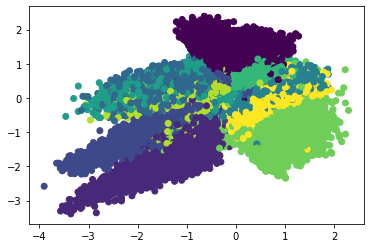

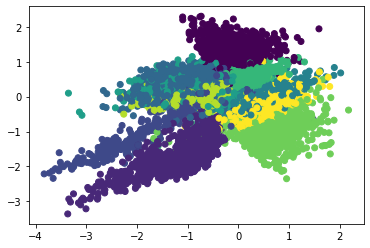

In [11]:
#plot_encoding((train_encoding, train_labels), (test_encoding, test_labels))
print(np.shape(train_encoding))
print(np.shape(train_encoding))
colors = train_labels

plt.scatter(train_encoding[:,0], train_encoding[:,1], c=colors)
plt.show()
colors = test_labels
plt.scatter(test_encoding[:,0], test_encoding[:,1], c=colors)
#plt.scatter(test_encoding[0:,0,0], test_encoding[0:,0,1], c="black", marker="x")
#for tex, enc in zip(test_labels, test_encoding):
#  plt.text(enc[0], enc[1], tex, horizontalalignment='left', size='medium', color='blue', weight='semibold')
#for enc in train_encoding:
#  plt.plot(enc[0], enc[1], '.')

For each of the digits 0, 1, $\ldots$, 9 we compute the average representation in the latent space by taking the mean of the encodings of the MNIST training data set.

In [12]:
# compute mean encoding
#train_mean_encodings = mean_encodings(train_encoding, train_labels)
print(np.shape(np.where(train_labels == 1)))
temp_train = np.asarray(train_encoding)
train_mean_encodings = np.zeros([10,2])
#train_mean_encodings = []
for i in range(0,10):
  dat = temp_train[np.where(train_labels == i)]
  x = dat[:,0]
  y = dat[:,1]
  #train_mean_encodings.append([np.mean(x), np.mean(y)])
  train_mean_encodings[i,0] = np.mean(x)
  train_mean_encodings[i,1] = np.mean(y)

(1, 6742)


In [ ]:
print(np.shape(train_mean_encodings))

(10, 2)


We visualize their location in the latent space.

C:\Users\rytte\AppData\Local\Temp/ipykernel_4140/3063936992.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  ax.scatter(train_encoding[ix,0], train_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)


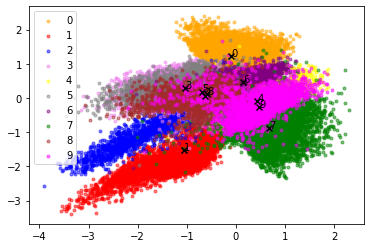

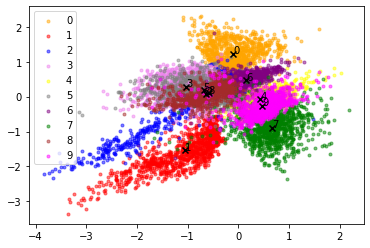

In [13]:
cdict = {0: 'orange', 1: 'red', 2: 'blue', 3: 'violet', 4: 'yellow', 5: 'grey', 6: 'purple', 7: 'green', 8: 'brown', 9: 'magenta'}
n = [0,1,2,3,4,5,6,7,8,9]

fig, ax = plt.subplots()
for g in np.unique(train_labels):
    ix = np.where(train_labels == g)
    ax.scatter(train_encoding[ix,0], train_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)
ax.legend()
plt.scatter(train_mean_encodings[:,0],train_mean_encodings[:,1], color='black', marker='x')

for i, txt in enumerate(n):
    ax.annotate(txt, (train_mean_encodings[i,0], train_mean_encodings[i,1]))
plt.show()

fig, ax = plt.subplots()
for g in np.unique(test_labels):
    ix = np.where(test_labels == g)
    ax.scatter(test_encoding[ix,0], test_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)
ax.legend()
plt.scatter(train_mean_encodings[:,0],train_mean_encodings[:,1], color='black', marker='x')

for i, txt in enumerate(n):
    ax.annotate(txt, (train_mean_encodings[i,0], train_mean_encodings[i,1]))
plt.show()



Of course, we can also decode the latent encodings with our model.

In [14]:
# compute mean images
train_mean_tensor = torch.tensor(train_mean_encodings)

with torch.no_grad():
    train_mean_images = model.decode(train_mean_tensor.float())

print(np.shape(train_mean_images))

torch.Size([10, 784])


tensor(1.0899)


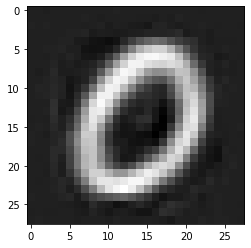

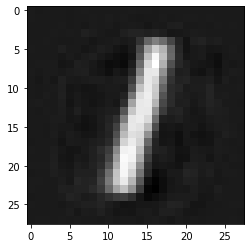

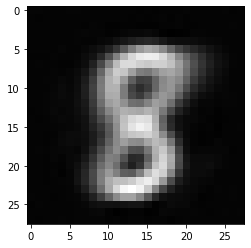

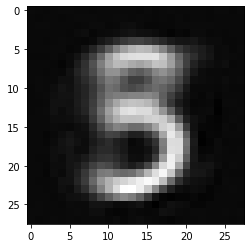

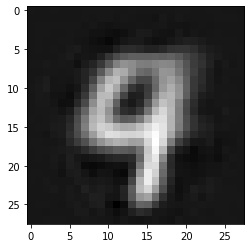

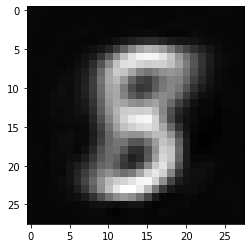

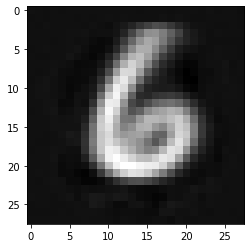

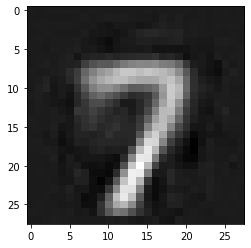

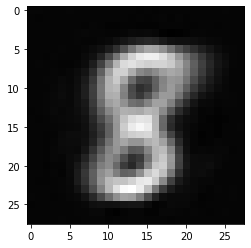

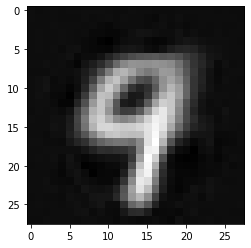

In [15]:
# compute mean images
#with torch.no_grad():
#    train_mean_images = model.decode(train_mean_encodings)

#plot_images(train_mean_images, torch.arange(10))
print(max(train_mean_images[1]))

  #print(np.shape(img.reshape(28,28)))
for img in train_mean_images:
  numimg = img.reshape(28,28)/max(img)

  plt.imshow(numimg, cmap='gray')
  plt.show()

Let us get a feeling for the distribution in the latent space by defining and analysing a whole grid of encodings, spanned by the mean encodings of the digits "0" and "9".

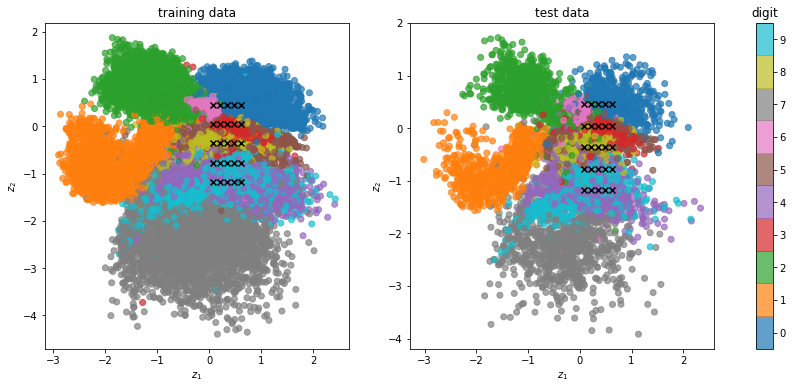

In [ ]:
# compute grid of latent vectors
zgrid = create_grid(train_mean_encodings[0], train_mean_encodings[9])

# visualize it
plot_encoding((train_encoding, train_labels), (test_encoding, test_labels), zgrid)

We show the corresponding decoded images.

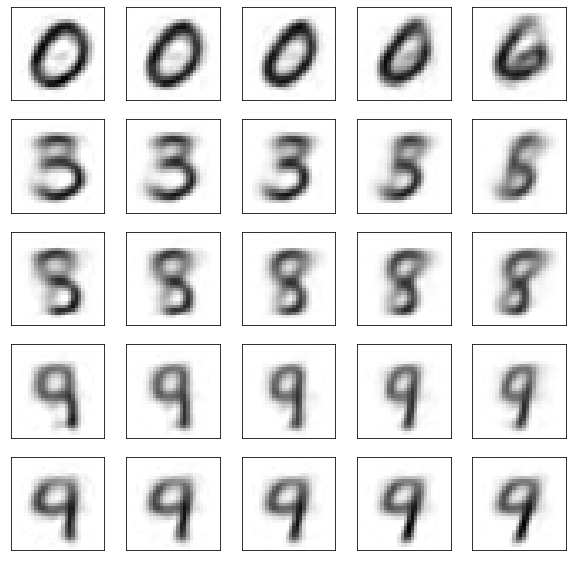

In [ ]:
# compute mean images
with torch.no_grad():
    xgrid = model.decode(zgrid)

plot_images(xgrid)

As in the previous parts of the lab session, we also compare the test images with their reconstructions to see how much information we lose by encoding the MNIST images in a two-dimensional space. We plot a set of images and their reconstructions, and compute the average squared reconstruction error as a more objective measure.

Average squared reconstruction error: 32.22705078125


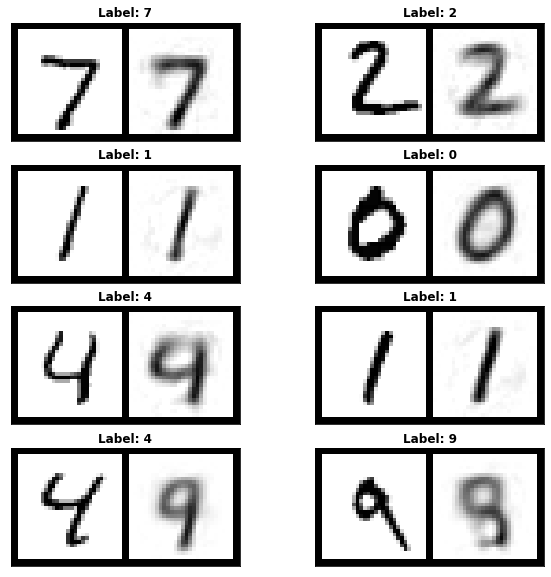

In [ ]:
# compute reconstruction
with torch.no_grad():
    test_reconstruction = model.decode(test_encoding)

# compute average squared reconstruction error
sqerr = (test_images - test_reconstruction).pow(2).sum(dim=1).mean()
print(f"Average squared reconstruction error: {sqerr}")

plot_reconstruction(test_images, test_reconstruction, test_labels)

## Task 8

Now we have performed exactly the same analysis as for the regular and the probabilistic PCA. Compare your results and answer Questions 4.8, 4.9, and 4.10 in the lab instructions.

We can also generate new MNIST-like images in the same way as for the nonlinear model without encoder. Again we sample 25 vectors $\mathbf{z}_1, \ldots, \mathbf{z}_{25}$ from $\mathcal{N}(0, \mathbf{I}_{2})$, and plot the representative decoding $\mu_{\boldsymbol{\theta}}(\mathbf{z}_n)$.

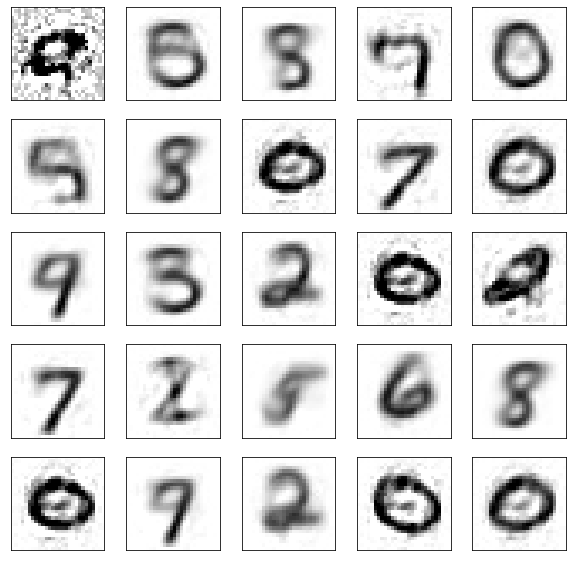

In [ ]:
with torch.no_grad():
  x = sample_decode(model, 25)

plot_images(x)

## Summary

We have trained a variational autoencoder that allows us to generate MNIST-like images. Adding a nonlinearity and an encoder seems to improve the quality of the samples. However, we also notice that the model is not perfect. Many further modifications of the decoder and encoder models are possible and could potentially improve the sampler. For instance, the dimension of the latent space can be increased (then the information loss by encoding the images in the latent space should be reduced). Alternatively the nonlinear decoder model can be changed: a more flexible model with increased number of layers in the neural network or a diagonal (or even full) covariance matrix could be used, or the outputs could be restricted to values between 0 and 1 (since we represent MNIST images as vectors with entries between 0 and 1).